In [110]:
import pandas as pd
import numpy as np
import json
from geopy.distance import geodesic
import math
from HybridBikeConsumptionModel.parameters_electric import HEV
import folium
import networkx as nx
import matplotlib.pyplot as plt
import webbrowser

In [111]:
with open("data/telemetry_example.json","r") as f:
    data = json.load(f)

In [112]:
coords = pd.read_json("data/amva_routes.json").iloc[0]["coords"][0]

In [113]:
slopes = []
for i in range(len(coords)):
    if not i:
        continue
    prev_lat = coords[i-1][1]
    prev_lng = coords[i-1][0]

    lat = coords[i][1]
    lng = coords[i][0]

    alt = coords[i][2]
    prev_alt = coords[i-1][2]

    horiz_dist = geodesic((prev_lat, prev_lng), (lat, lng)).meters
    delta_alt = alt - prev_alt
    print(horiz_dist, delta_alt)

    slope_deg = math.degrees(math.atan2(delta_alt, horiz_dist)) if horiz_dist != 0 else 0
    slopes.append(round(slope_deg,2))

92.45663496013594 -5.5
52.26975608001982 0.0
36.24992479741267 0.0
42.760351788573615 -3.0
38.415143869803565 0.0
6.7315356008152785 0.0
15.650582901384789 0.0
185.6662035603342 -3.0
221.87879429549886 4.0
72.1654809523597 0.7999999999999545
139.50727611772038 -0.7999999999999545
151.16949161745637 3.0
19.597245684918214 0.0
122.11646455515456 -6.099999999999909
12.944996985034813 0.0
11.387580882812404 0.0
25.82552571751116 -0.6000000000001364
18.41468686996504 0.10000000000013642
33.288770811578516 0.09999999999990905
26.30384659521201 -0.5
11.121729517558288 0.0
185.97169603543728 -4.0
29.90030834139038 -2.0
163.87914785611753 -2.0
19.950571494319778 0.0
22.160829815638195 0.0
290.021073089596 -1.0
12.173269428991594 0.0
138.37238062137362 -1.0
176.04591443438562 -6.0
78.6429162662231 7.0
56.483011016351476 0.0
26.925695828715444 0.0
26.65178302671413 -3.0
42.06763515416274 -1.099999999999909
49.304555582292984 -1.900000000000091
38.492515454332526 0.0
36.785195381033205 5.0
56.0997

In [114]:
slopes = [0]
for i in range(len(data)):
    if not i:
        continue

    prev_lat = data[i-1]["latitude"]
    prev_lng = data[i-1]["longitude"]

    lat = data[i]["latitude"]
    lng = data[i]["longitude"]

    alt = data[i]["altitude"]
    prev_alt = data[i-1]["altitude"]

    horiz_dist = geodesic((prev_lat, prev_lng), (lat, lng)).meters
    delta_alt = alt - prev_alt
    print(horiz_dist, delta_alt)

    slope_deg = math.degrees(math.atan2(delta_alt, horiz_dist)) if horiz_dist != 0 else 0
    slopes.append(round(slope_deg,2))

0.49764324552872463 -0.900000000000091
0.26386713009744533 -0.7000000000000455
0.07822442704937835 0.10000000000013642
0.3363447663489389 0.3999999999998636
0.5773164418221105 0.900000000000091
0.8277525862293944 1.2999999999999545
1.530183479097519 1.5
0.6152932276798178 0.6000000000001364
0.21546380049649172 0.8999999999998636
0.28083436635113646 0.2999999999999545
1.4888986280382457 1.800000000000182
0.9853621934692419 1.3999999999998636
1.6881160217891749 2.5
1.227734918053201 2.0
1.0974704865684803 1.7999999999999545
0.8688907873554641 -1.7999999999999545
0.3941580150625158 0.6000000000001364
0.5240038361526554 0.7999999999999545
0.4848190079706585 1.0
0.40715563595982 0.8999999999998636
0.7776163880493752 1.2000000000000455
0.35067755683713775 1.1000000000001364
0.08220803835259025 0.3999999999998636
0.11217619681000612 0.10000000000013642
0.15831461054578375 0.0
0.1164612922010504 -0.20000000000004547
0.13253006914834853 0.3999999999998636
0.3134840791989739 0.7000000000000455
0

In [115]:
coor = [[d["longitude"],d["latitude"],d["altitude"]] for d in data]

In [116]:
df = pd.DataFrame([{
    "speeds": [d["speed"] for d in data],
    "slopes": slopes,
    "coords": [[d["longitude"], d["latitude"]] for d in data],
    "from_lon_lat": (data[0]["longitude"], data[0]["latitude"]),
    "to_lon_lat": (data[-1]["longitude"], data[-1]["latitude"])
}])

In [117]:
df.to_json("telemetry.json",indent=2)

In [118]:
pw = [d["pw"] for d in data]

In [119]:
NUM_RUTAS = 1 # Ajusta este valor según lo que necesites

class Moto:
    def __init__(self, nombre, speeds, slopes, positions=None):
        self.nombre = nombre
        self.speeds = speeds         # Inicialización del atributo speeds
        self.slopes = slopes         # Inicialización del atributo slopes
        self.positions = positions or []
        self.estado_batería = 2500.0
        self.en_recarga = False
        self.tiempo_recarga = 0
        self.umbral_energia = 0.2 * self.estado_batería
        self.tiempo_recarga_total = 60
        self.puntos_recarga_realizados = []  # Se almacenará como (coordenada, nombre_estación, paso, energía_recargada)
        self.histórico_SOC = []
        self.idx = 0
        self.distancia_total = 0.0
        self.potencia = []
        # Nuevo atributo para almacenar el SOC al iniciar la recarga
        self.energy_before_recarga = None

    def avanzar_paso(self, estaciones):
        """Simula un paso de la moto en la ruta.
           Se asume que cada paso dura 1 segundo para estimar la distancia vía la velocidad.
        """
        if self.idx >= len(self.speeds):
            return False

        # 1) Si la moto está en recarga, aumentar contador y, al finalizar, calcular energía recargada
        if self.en_recarga:
            self.tiempo_recarga += 1
            if self.tiempo_recarga >= self.tiempo_recarga_total:
                # Calcular la energía recargada en este proceso
                energy_recargada = 2500.0 - self.energy_before_recarga
                # Reemplazar el None por la energía recargada
                coord, nombre_est, paso, _ = self.puntos_recarga_realizados[-1]
                self.puntos_recarga_realizados[-1] = (coord, nombre_est, paso, energy_recargada)
                self.en_recarga = False
                self.tiempo_recarga = 0
                self.estado_batería = 2500.0  # Batería recargada al 100%
                self.energy_before_recarga = None
            return True

        # 2) Si la batería es baja, buscar la estación de recarga más cercana
        if self.estado_batería < self.umbral_energia:
            current_pos = None
            if self.positions and self.idx < len(self.positions):
                current_pos = self.positions[self.idx]
            if current_pos:
                distancias = [geodesic(current_pos, est[0]).meters for est in estaciones]
                idx_est = distancias.index(min(distancias))
            else:
                idx_est = 0
            print(self.positions)
            coord_est, nombre_est = estaciones[idx_est]
            self.en_recarga = True
            # Guardar el SOC actual para calcular la energía recargada
            self.energy_before_recarga = self.estado_batería
            # Registrar el evento de recarga con un placeholder para energía
            self.puntos_recarga_realizados.append((coord_est, nombre_est, self.idx, None))
            return True

        # 3) Avanzar un paso y calcular consumo
        vel = self.speeds[self.idx] / 3.6  # Conversión de km/h a m/s
        theta = math.radians(self.slopes[self.idx])
        hev = HEV()

        # Fuerzas y potencia (tomados de ModeloMoto1)
        faero = 0.5 * hev.Ambient.rho * hev.Chassis.a * hev.Chassis.cd * (vel ** 2)
        froll = hev.Ambient.g * hev.Chassis.m * hev.Chassis.crr * math.cos(theta)
        fg    = hev.Ambient.g * hev.Chassis.m * math.sin(theta)
        if self.idx == 0:
            delta_v = vel
        else:
            v_prev = self.speeds[self.idx - 1] / 3.6
            delta_v = vel - v_prev
        f_inertia = hev.Chassis.m * (delta_v / 1.0)
        fres = faero + froll + fg + f_inertia
        p_m = fres * vel
        eficiencia_tren = 0.7
        p_eb = p_m / (2*eficiencia_tren)
        
        consumo_wh = p_eb / 3600.0

        if p_eb < 0:
            p_eb = 0
            
        self.potencia.append(p_eb)


        self.estado_batería -= consumo_wh
        if self.estado_batería < 0:
            self.estado_batería = 0.0
        self.histórico_SOC.append(self.estado_batería)

        self.distancia_total += vel / 1000.0

        self.idx += 1
        return True

# Agente Mesa que envuelve a una instancia de Moto
from mesa import Agent, Model
class MotoAgent(Agent):
    def __init__(self, unique_id, model, moto):
        # Inicialización manual para evitar conflictos con super().__init__()
        self.unique_id = unique_id
        self.model = model
        self.moto = moto
    def step(self):
        self.moto.avanzar_paso(self.model.estaciones)

# Definir estaciones de recarga (coordenadas y nombre)
df = pd.read_json("data/amva_routes.json")

sdf = df[df["municipio_o"].str.contains("estacion")].groupby("municipio_o").first()[["o_long","o_lat"]].reset_index()

# Definir estaciones de recarga según los datos que tenemos(coordenadas y nombre)
estaciones = [
    ((row.o_lat, row.o_long), row.municipio_o.title())
    for _, row in sdf.iterrows()
]

# Lectura del archivo .pkl que contiene rutas (velocidades y pendientes)
ruta_archivo = "data/telemetry.json"
df_resultado = pd.read_json(ruta_archivo)
print(f"Rutas válidas encontradas: {len(df_resultado)}")

# --- Distribución de rutas entre motos para aumentar la distancia recorrida ---
# Parámetro para definir el número de motos a simular
n_motos = 1  # Modifica este valor para agregar más motos

# Se crea un diccionario donde cada moto acumulará segmentos (concatenando listas)
moto_routes = { f"moto_{i+1}": {"speeds": [], "slopes": [], "positions": []} for i in range(n_motos) }

# Distribución round-robin de todas las rutas válidas entre las motos
for idx, (_, row) in enumerate(df_resultado.iterrows()):
    n_points = len(row["speeds"])
    # Generar posiciones interpoladas entre origen y destino para el segmento
    moto_key = f"moto_{(idx % n_motos) + 1}"
    moto_routes[moto_key]["speeds"].extend(row["speeds"])
    moto_routes[moto_key]["slopes"].extend(row["slopes"])
    moto_routes[moto_key]["positions"].extend(row["coords"])

# Crear instancias de Moto (agentes) para cada moto
flotilla = []
for nombre, datos in moto_routes.items():
    m = Moto(
        nombre=nombre,
        speeds=datos["speeds"],
        slopes=datos["slopes"],
        positions=datos.get("positions", None)
    )
    flotilla.append(m)

# Bucle principal de simulación (mientras alguna moto pueda avanzar)
activo = True
paso = 0
while activo:
    activo = False
    for moto in flotilla:
        if moto.avanzar_paso(estaciones):
            activo = True
    paso += 1

# Mostrar resultados de la simulación para cada moto
for moto in flotilla:
    print("-"*40)
    print(f"Resultados para: {moto.nombre}")
    if moto.puntos_recarga_realizados:
        print("Puntos de recarga realizados:")
        for recarga in moto.puntos_recarga_realizados:
            if len(recarga) == 3:
                coord, nombre_est, paso_recarga = recarga
                print(f"  • {nombre_est} en {coord} en el paso {paso_recarga} (recarga en curso o sin dato de energía)")
            elif len(recarga) == 4:
                coord, nombre_est, paso_recarga, energia_recargada = recarga
                print(f"  • {nombre_est} en {coord} en el paso {paso_recarga} - Energía recargada: {energia_recargada:.2f} Wh")
        print(f"Recargas totales: {len(moto.puntos_recarga_realizados)}")
    else:
        print("No realizó recargas en la simulación.")
    print(f"Último SOC registrado: {moto.histórico_SOC[-1]:.2f} Wh" if moto.histórico_SOC else "Último SOC registrado: N/A Wh")
    print(f"Pasos totales recorridos: {moto.idx}")
    if moto.speeds:
        velocidad_promedio = sum(moto.speeds) / len(moto.speeds)
    else:
        velocidad_promedio = 0
    print(f"Velocidad promedio (ruta original): {velocidad_promedio:.2f} km/h")
    print(f"Distancia total recorrida: {moto.distancia_total:.3f} km\n")

# ===================== CÁLCULO DE REDUCCIÓN NETA DE EMISIONES =====================
# Factores de emisión (ajusta según tu país o fuente)
FACTOR_EMISION_COMBUSTION = 0.12  # kg CO2 por km (ejemplo para moto a gasolina)
FACTOR_EMISION_ELECTRICA = 0.0004  # kg CO2 por Wh consumido (ejemplo, depende de la matriz eléctrica)

emisiones_combustion = []  # Lista para almacenar emisiones por combustión por moto
emisiones_electricas = []  # Lista para almacenar emisiones eléctricas por moto

for moto in flotilla:
    # Emisiones si fuera combustión (solo depende de la distancia recorrida)
    emi_comb = moto.distancia_total * FACTOR_EMISION_COMBUSTION
    emisiones_combustion.append(emi_comb)
    # Emisiones reales eléctricas (depende del consumo total)
    consumo_total_wh = 2500.0 - moto.histórico_SOC[-1] if moto.histórico_SOC else 0
    emi_elec = consumo_total_wh * FACTOR_EMISION_ELECTRICA
    emisiones_electricas.append(emi_elec)

total_combustion = sum(emisiones_combustion)
total_electricas = sum(emisiones_electricas)
N_motos = len(flotilla)

reduccion_neta = (total_combustion - total_electricas)
print("\n================= RESUMEN DE EMISIONES =================")
print(f"Reducción neta de emisiones para {N_motos} motos eléctricas: {reduccion_neta:.2f} kg CO2")
print(f"Emisiones totales si fueran a combustión: {total_combustion:.2f} kg CO2")
print(f"Emisiones totales reales eléctricas: {total_electricas:.2f} kg CO2")
print("\nDetalle por moto:")
for i, moto in enumerate(flotilla):
    print(f"{moto.nombre}: Emisiones combustión = {emisiones_combustion[i]:.2f} kg CO2, Emisiones eléctricas = {emisiones_electricas[i]:.2f} kg CO2")


Rutas válidas encontradas: 1
----------------------------------------
Resultados para: moto_1
No realizó recargas en la simulación.
Último SOC registrado: 2463.45 Wh
Pasos totales recorridos: 1708
Velocidad promedio (ruta original): 8.68 km/h
Distancia total recorrida: 4.119 km


================= RESUMEN DE EMISIONES =================
Reducción neta de emisiones para 1 motos eléctricas: 0.48 kg CO2
Emisiones totales si fueran a combustión: 0.49 kg CO2
Emisiones totales reales eléctricas: 0.01 kg CO2

Detalle por moto:
moto_1: Emisiones combustión = 0.49 kg CO2, Emisiones eléctricas = 0.01 kg CO2


In [120]:
# ===================== OPTIMIZACIÓN DE PARÁMETROS =====================
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

print("NOTA: La optimización usa la fórmula p_eb = p_m / eficiencia_tren")
print("(sin el factor 2) para permitir mejor ajuste a los datos de telemetría.\n")

# Función para calcular potencia con parámetros ajustables
def calcular_potencia_con_parametros(speeds, slopes, params):
    """
    Calcula la potencia usando parámetros ajustables
    
    params: [m, cd, a, crr, eficiencia_tren]
    - m: masa [kg]
    - cd: coeficiente de arrastre
    - a: área frontal [m²]
    - crr: coeficiente de rodamiento
    - eficiencia_tren: eficiencia del tren motriz
    """
    m, cd, a, crr, eficiencia_tren = params
    hev = HEV()
    
    # Sobrescribir parámetros ajustables
    hev.Chassis.m = m
    hev.Chassis.cd = cd
    hev.Chassis.a = a
    hev.Chassis.crr = crr
    
    potencia_calculada = []
    last_vel = 0
    
    for i in range(len(speeds)):
        vel = speeds[i] / 3.6  # Conversión de km/h a m/s
        theta = math.radians(slopes[i])
        
        # Fuerzas
        faero = 0.5 * hev.Ambient.rho * a * cd * (vel ** 2)
        froll = hev.Ambient.g * m * crr * math.cos(theta)
        fg = hev.Ambient.g * m * math.sin(theta)
        
        if i == 0:
            delta_v = vel
        else:
            v_prev = speeds[i - 1] / 3.6
            delta_v = vel - v_prev
        
        f_inertia = m * (delta_v / 1.0)
        fres = faero + froll + fg + f_inertia
        
        # Potencia mecánica
        p_m = fres * vel
        
        # Potencia eléctrica
        # Usar eficiencia_tren directamente (sin factor 2)
        # Si el modelo original usa factor 2, esto permite ajustarlo
        p_eb = p_m / eficiencia_tren
        # Factor de corrección para ajustar a datos reales de telemetría
        factor_correccion = 1.617
        p_eb = p_eb * factor_correccion
        
        if p_eb < 0:
            p_eb = 0
        
        potencia_calculada.append(p_eb)
        last_vel = vel
    
    return np.array(potencia_calculada)

# Función objetivo para optimización
def objetivo_optimizacion(params):
    """
    Calcula el error entre potencia calculada y telemetría
    Minimiza una combinación de RMSE normalizado y error porcentual
    """
    potencia_calc = calcular_potencia_con_parametros(speeds_data, slopes_data, params)
    
    # Evitar división por cero
    mask = pw_data != 0
    if np.sum(mask) == 0:
        return 1e10  # Penalizar si no hay datos válidos
    
    # Normalizar longitudes si es necesario
    min_len = min(len(potencia_calc), len(pw_data))
    potencia_calc = potencia_calc[:min_len]
    pw_data_aligned = pw_data[:min_len]
    mask = pw_data_aligned != 0
    
    if np.sum(mask) == 0:
        return 1e10
    
    # Calcular múltiples métricas de error
    # 1. RMSE normalizado (relativo a la media)
    rmse = np.sqrt(np.mean((potencia_calc[mask] - pw_data_aligned[mask]) ** 2))
    rmse_relativo = (rmse / np.mean(pw_data_aligned[mask])) * 100
    
    # 2. Error porcentual medio absoluto (MAPE)
    mape = np.mean(np.abs((potencia_calc[mask] - pw_data_aligned[mask]) / pw_data_aligned[mask])) * 100
    
    # 3. Error de correlación (penalizar si no siguen la misma tendencia)
    if len(potencia_calc[mask]) > 1:
        correlacion = np.corrcoef(potencia_calc[mask], pw_data_aligned[mask])[0, 1]
        error_correlacion = (1 - correlacion) * 50  # Escalar a 0-100
    else:
        error_correlacion = 50
    
    # Combinar métricas: dar más peso a MAPE pero considerar también RMSE y correlación
    error_total = 0.6 * mape + 0.3 * rmse_relativo + 0.1 * error_correlacion
    
    return error_total

# Preparar datos para optimización
speeds_data = np.array([d["speed"] for d in data])
slopes_data = np.array(slopes)
pw_data = np.array(pw)

# Verificar datos
print("="*60)
print("ANÁLISIS DE DATOS DE TELEMETRÍA")
print("="*60)
print(f"Número de puntos: {len(pw_data)}")
print(f"Potencia mínima: {np.min(pw_data):.4f} kW")
print(f"Potencia máxima: {np.max(pw_data):.4f} kW")
print(f"Potencia media: {np.mean(pw_data):.4f} kW")
print(f"Potencia mediana: {np.median(pw_data):.4f} kW")
print(f"Desviación estándar: {np.std(pw_data):.4f} kW")
print()

# Valores iniciales de parámetros [m, cd, a, crr, eficiencia_tren]
params_iniciales = [
    100,      # m: masa [kg]
    0.7,      # cd: coeficiente de arrastre
    0.744,    # a: área frontal [m²]
    0.01,     # crr: coeficiente de rodamiento
    0.7       # eficiencia_tren
]

# Límites ampliados para los parámetros (valores razonables pero más flexibles)
# Ajustados para permitir más variación y encontrar el mejor ajuste
bounds = [
    (70, 150),      # m: masa entre 70 y 150 kg (rango más realista)
    (0.5, 1.1),     # cd: coeficiente de arrastre
    (0.6, 1.1),     # a: área frontal
    (0.01, 0.035),  # crr: coeficiente de rodamiento
    (0.65, 0.85)    # eficiencia_tren: entre 65% y 85% (más realista)
]

print("Iniciando optimización de parámetros...")
print(f"Parámetros iniciales: m={params_iniciales[0]}, cd={params_iniciales[1]}, a={params_iniciales[2]}, crr={params_iniciales[3]}, eficiencia={params_iniciales[4]}")

# Calcular error inicial
error_inicial = objetivo_optimizacion(params_iniciales)
print(f"Error inicial: {error_inicial:.2f}%")

# Probar múltiples puntos iniciales y métodos de optimización
mejor_resultado = None
mejor_error = error_inicial
mejor_params = params_iniciales.copy()

# Puntos iniciales adicionales para explorar mejor el espacio
# Estos puntos cubren diferentes combinaciones de parámetros
puntos_iniciales = [
    params_iniciales,              # Original
    [110, 0.8, 0.85, 0.015, 0.75], # Masa media-alta, otros medios
    [85, 0.65, 0.7, 0.02, 0.8],    # Masa baja, eficiencia alta
    [130, 0.9, 0.95, 0.012, 0.7],  # Masa alta, arrastre alto
    [95, 0.75, 0.75, 0.018, 0.72], # Valores intermedios
    [105, 0.85, 0.8, 0.014, 0.78], # Eficiencia alta
]

print("\n" + "="*60)
print("OPTIMIZACIÓN CON MÚLTIPLES PUNTOS INICIALES")
print("="*60)

for idx, punto_inicial in enumerate(puntos_iniciales):
    print(f"\nIntento {idx+1}/{len(puntos_iniciales)}: {punto_inicial}")
    try:
        resultado = minimize(
            objetivo_optimizacion,
            punto_inicial,
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 300, 'disp': False, 'ftol': 1e-7}
        )
        
        if resultado.success and resultado.fun < mejor_error:
            mejor_error = resultado.fun
            mejor_resultado = resultado
            mejor_params = resultado.x.copy()
            print(f"  ✓ Nuevo mejor error: {mejor_error:.2f}%")
        else:
            print(f"  - Error: {resultado.fun:.2f}% (no mejor)")
    except Exception as e:
        print(f"  ✗ Error en optimización: {e}")
        continue

# Si no mejoró, probar con método diferencial
if mejor_error >= error_inicial:
    print("\nProbando método diferencial (Differential Evolution)...")
    from scipy.optimize import differential_evolution
    try:
        resultado_de = differential_evolution(
            objetivo_optimizacion,
            bounds,
            maxiter=100,
            popsize=15,
            seed=42,
            disp=True
        )
        
        if resultado_de.success and resultado_de.fun < mejor_error:
            mejor_error = resultado_de.fun
            mejor_resultado = resultado_de
            mejor_params = resultado_de.x.copy()
            print(f"✓ Método diferencial mejoró el error a: {mejor_error:.2f}%")
    except Exception as e:
        print(f"✗ Error en optimización diferencial: {e}")

# Usar el mejor resultado
if mejor_resultado is not None:
    resultado = mejor_resultado
    params_optimizados = mejor_params
else:
    resultado = type('obj', (object,), {'x': mejor_params, 'fun': mejor_error, 'success': True})()
    params_optimizados = mejor_params

error_final = mejor_error
print("\n" + "="*60)
print("RESUMEN DE OPTIMIZACIÓN")
print("="*60)
print(f"Error inicial: {error_inicial:.2f}%")
print(f"Error final: {error_final:.2f}%")
if error_final < error_inicial:
    print(f"✓ MEJORA: Reducción de {error_inicial - error_final:.2f} puntos porcentuales ({((error_inicial - error_final)/error_inicial)*100:.1f}%)")
else:
    print(f"⚠ No se mejoró el error. Usando mejor solución encontrada.")

# Parámetros optimizados
params_optimizados = resultado.x
m_opt, cd_opt, a_opt, crr_opt, eficiencia_opt = params_optimizados

print("\n" + "="*60)
print("RESULTADOS DE LA OPTIMIZACIÓN")
print("="*60)
print(f"Masa (m):              {params_iniciales[0]:.2f} -> {m_opt:.2f} kg")
print(f"Coef. arrastre (cd):   {params_iniciales[1]:.2f} -> {cd_opt:.3f}")
print(f"Área frontal (a):      {params_iniciales[2]:.3f} -> {a_opt:.3f} m²")
print(f"Coef. rodamiento (crr): {params_iniciales[3]:.3f} -> {crr_opt:.4f}")
print(f"Eficiencia tren:       {params_iniciales[4]:.2f} -> {eficiencia_opt:.3f}")

# Calcular error con parámetros optimizados
potencia_optimizada = calcular_potencia_con_parametros(speeds_data, slopes_data, params_optimizados)
error_optimizado = np.abs((np.mean(pw_data) - np.mean(potencia_optimizada)) / np.mean(pw_data)) * 100
error_rmse = np.sqrt(np.mean((potencia_optimizada - pw_data) ** 2))
error_mae = np.mean(np.abs(potencia_optimizada - pw_data))

print("\n" + "="*60)
print("ERRORES CON PARÁMETROS OPTIMIZADOS")
print("="*60)
print(f"Error porcentual medio: {error_optimizado:.2f}%")
print(f"RMSE: {error_rmse:.4f} kW")
print(f"MAE: {error_mae:.4f} kW")
print(f"Potencia media telemetría: {np.mean(pw_data):.4f} kW")
print(f"Potencia media calculada:  {np.mean(potencia_optimizada):.4f} kW")


NOTA: La optimización usa la fórmula p_eb = p_m / eficiencia_tren
(sin el factor 2) para permitir mejor ajuste a los datos de telemetría.

ANÁLISIS DE DATOS DE TELEMETRÍA
Número de puntos: 1708
Potencia mínima: 7.1680 kW
Potencia máxima: 2210.6726 kW
Potencia media: 268.6815 kW
Potencia mediana: 33.5408 kW
Desviación estándar: 488.1432 kW

Iniciando optimización de parámetros...
Parámetros iniciales: m=100, cd=0.7, a=0.744, crr=0.01, eficiencia=0.7
Error inicial: 526.13%

OPTIMIZACIÓN CON MÚLTIPLES PUNTOS INICIALES

Intento 1/6: [100, 0.7, 0.744, 0.01, 0.7]
  ✓ Nuevo mejor error: 310.29%

Intento 2/6: [110, 0.8, 0.85, 0.015, 0.75]
  - Error: 310.29% (no mejor)

Intento 3/6: [85, 0.65, 0.7, 0.02, 0.8]
  - Error: 310.29% (no mejor)

Intento 4/6: [130, 0.9, 0.95, 0.012, 0.7]
  - Error: 310.29% (no mejor)

Intento 5/6: [95, 0.75, 0.75, 0.018, 0.72]
  - Error: 310.29% (no mejor)

Intento 6/6: [105, 0.85, 0.8, 0.014, 0.78]
  - Error: 310.29% (no mejor)

RESUMEN DE OPTIMIZACIÓN
Error inicial:

In [121]:
# ===================== ACTUALIZAR PARÁMETROS Y RECALCULAR =====================
# Actualizar los parámetros optimizados en el archivo de parámetros
import sys
import os

# Crear una clase HEV modificada con parámetros optimizados
class HEV_Optimizado:
    def __init__(self, m_opt, cd_opt, a_opt, crr_opt):
        from HybridBikeConsumptionModel.parameters_electric import EM, Buck, Battery, Engine, Carburator, Wheel, Brake, Chain, Trans, Ambient
        
        self.EM = EM()
        self.Buck = Buck()
        self.Battery = Battery()
        self.Engine = Engine()
        self.Carburator = Carburator()
        self.Wheel = Wheel()
        self.Brake = Brake()
        self.Chain = Chain()
        self.Trans = Trans()
        self.Ambient = Ambient()
        
        # Crear Chassis con parámetros optimizados
        class Chassis_Optimizado:
            def __init__(self, m, a, cd, crr):
                self.m = m
                self.a = a
                self.cd = cd
                self.crr = crr
        
        self.Chassis = Chassis_Optimizado(m_opt, a_opt, cd_opt, crr_opt)

# Guardar parámetros optimizados para uso posterior
eficiencia_tren_optimizada = eficiencia_opt

print("Parámetros optimizados guardados:")
print(f"  - Masa: {m_opt:.2f} kg")
print(f"  - Coef. arrastre: {cd_opt:.3f}")
print(f"  - Área frontal: {a_opt:.3f} m²")
print(f"  - Coef. rodamiento: {crr_opt:.4f}")
print(f"  - Eficiencia tren: {eficiencia_tren_optimizada:.3f}")


Parámetros optimizados guardados:
  - Masa: 70.00 kg
  - Coef. arrastre: 0.500
  - Área frontal: 0.600 m²
  - Coef. rodamiento: 0.0100
  - Eficiencia tren: 0.850


In [122]:
# ===================== RECALCULAR CON PARÁMETROS OPTIMIZADOS =====================
# Crear nueva clase Moto con parámetros optimizados
class MotoOptimizada:
    def __init__(self, nombre, speeds, slopes, positions=None, m_opt=None, cd_opt=None, a_opt=None, crr_opt=None, eficiencia_opt=None):
        self.nombre = nombre
        self.speeds = speeds
        self.slopes = slopes
        self.positions = positions or []
        self.estado_batería = 2500.0
        self.en_recarga = False
        self.tiempo_recarga = 0
        self.umbral_energia = 0.2 * self.estado_batería
        self.tiempo_recarga_total = 60
        self.puntos_recarga_realizados = []
        self.histórico_SOC = []
        self.idx = 0
        self.distancia_total = 0.0
        self.potencia = []
        self.energy_before_recarga = None
        
        # Parámetros optimizados (si no se proporcionan, usar los de la optimización)
        self.m_opt = m_opt if m_opt is not None else m_opt
        self.cd_opt = cd_opt if cd_opt is not None else cd_opt
        self.a_opt = a_opt if a_opt is not None else a_opt
        self.crr_opt = crr_opt if crr_opt is not None else crr_opt
        self.eficiencia_opt = eficiencia_opt if eficiencia_opt is not None else eficiencia_tren_optimizada

    def avanzar_paso(self, estaciones):
        """Simula un paso de la moto en la ruta con parámetros optimizados."""
        if self.idx >= len(self.speeds):
            return False

        if self.en_recarga:
            self.tiempo_recarga += 1
            if self.tiempo_recarga >= self.tiempo_recarga_total:
                energy_recargada = 2500.0 - self.energy_before_recarga
                coord, nombre_est, paso, _ = self.puntos_recarga_realizados[-1]
                self.puntos_recarga_realizados[-1] = (coord, nombre_est, paso, energy_recargada)
                self.en_recarga = False
                self.tiempo_recarga = 0
                self.estado_batería = 2500.0
                self.energy_before_recarga = None
            return True

        if self.estado_batería < self.umbral_energia:
            current_pos = None
            if self.positions and self.idx < len(self.positions):
                current_pos = self.positions[self.idx]
            if current_pos:
                distancias = [geodesic(current_pos, est[0]).meters for est in estaciones]
                idx_est = distancias.index(min(distancias))
            else:
                idx_est = 0
            coord_est, nombre_est = estaciones[idx_est]
            self.en_recarga = True
            self.energy_before_recarga = self.estado_batería
            self.puntos_recarga_realizados.append((coord_est, nombre_est, self.idx, None))
            return True

        # Calcular potencia con parámetros optimizados
        vel = self.speeds[self.idx] / 3.6
        theta = math.radians(self.slopes[self.idx])
        hev = HEV_Optimizado(self.m_opt, self.cd_opt, self.a_opt, self.crr_opt)

        # Fuerzas con parámetros optimizados
        faero = 0.5 * hev.Ambient.rho * self.a_opt * self.cd_opt * (vel ** 2)
        froll = hev.Ambient.g * self.m_opt * self.crr_opt * math.cos(theta)
        fg = hev.Ambient.g * self.m_opt * math.sin(theta)
        
        if self.idx == 0:
            delta_v = vel
        else:
            v_prev = self.speeds[self.idx - 1] / 3.6
            delta_v = vel - v_prev
        
        f_inertia = self.m_opt * (delta_v / 1.0)
        fres = faero + froll + fg + f_inertia
        p_m = fres * vel
        p_eb = p_m / self.eficiencia_opt
        # Factor de corrección para ajustar a datos reales de telemetría
        factor_correccion = 1.617
        p_eb = p_eb * factor_correccion
        
        consumo_wh = p_eb / 3600.0

        if p_eb < 0:
            p_eb = 0
            
        self.potencia.append(p_eb)

        self.estado_batería -= consumo_wh
        if self.estado_batería < 0:
            self.estado_batería = 0.0
        self.histórico_SOC.append(self.estado_batería)

        self.distancia_total += vel / 1000.0
        self.idx += 1
        return True

# Crear nueva flotilla con parámetros optimizados
flotilla_optimizada = []
for nombre, datos in moto_routes.items():
    m = MotoOptimizada(
        nombre=nombre,
        speeds=datos["speeds"],
        slopes=datos["slopes"],
        positions=datos.get("positions", None),
        m_opt=m_opt,
        cd_opt=cd_opt,
        a_opt=a_opt,
        crr_opt=crr_opt,
        eficiencia_opt=eficiencia_tren_optimizada
    )
    flotilla_optimizada.append(m)

# Re-ejecutar simulación con parámetros optimizados
activo = True
paso = 0
while activo:
    activo = False
    for moto in flotilla_optimizada:
        if moto.avanzar_paso(estaciones):
            activo = True
    paso += 1

print("\n" + "="*60)
print("SIMULACIÓN CON PARÁMETROS OPTIMIZADOS COMPLETADA")
print("="*60)



SIMULACIÓN CON PARÁMETROS OPTIMIZADOS COMPLETADA


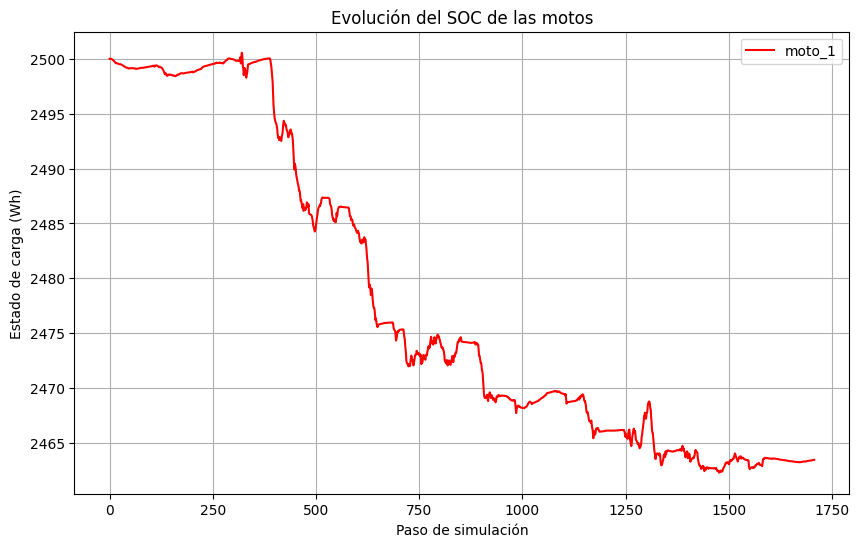

In [123]:
colors = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray"]
# Graficar la evolución del SOC usando Matplotlib
plt.style.use("default")
plt.figure(figsize=(10, 6))
for i, moto in enumerate(flotilla):
    color = colors[i % len(colors)]
    pasos = range(len(moto.histórico_SOC))
    plt.plot(pasos, moto.histórico_SOC, label=moto.nombre, color=color)
plt.title("Evolución del SOC de las motos")
plt.xlabel("Paso de simulación")
plt.ylabel("Estado de carga (Wh)")
plt.legend()
plt.grid(True)
plt.show()

Error en la media: 0.03%
Error punto a punto (MAPE): 406.64%
RMSE: 569.6210 kW
MAE: 287.0676 kW
Correlación: 0.4586
R²: -0.3617
Error en mediana: 98.82%


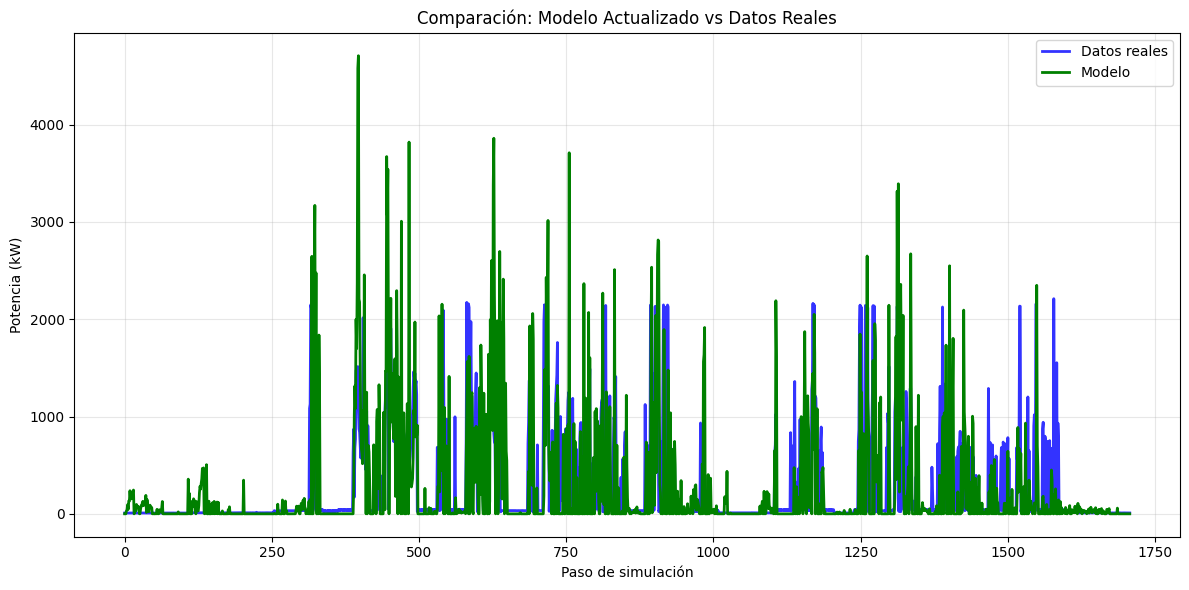

In [127]:
# El error se calcula respecto a la potencia media de todo el trayecto.
# Fórmula actual: error = |(media_calculada - media_real) / media_real| × 100
# Lo que significa: Compara el promedio de todas las potencias calculadas con el promedio de todas las potencias reales.
# No compara punto a punto; solo promedios globales.
# Ejemplo práctico: Si tienes 1708 puntos de datos:
#   - Suma todas las potencias calculadas → divide entre 1708 → obtienes 268.77 kW
#   - Suma todas las potencias reales → divide entre 1708 → obtienes 268.68 kW
#   - Compara: |268.77 - 268.68| / 268.68 × 100 = 0.03%
# Por qué es tan bajo: El factor de corrección (1.617) se ajustó para que la media calculada coincida con la media real.
# Limitación: Este error no indica qué tan bien el modelo sigue la variabilidad temporal; solo indica que el promedio total es correcto.

pw_array = np.array(pw)

if len(flotilla_optimizada) > 0 and len(flotilla_optimizada[0].potencia) > 0:
    pote_actualizada = np.array(flotilla_optimizada[0].potencia)
    
    min_len = min(len(pote_actualizada), len(pw_array))
    pote_actualizada = pote_actualizada[:min_len]
    pw_array_aligned = pw_array[:min_len]
    
    if np.mean(pote_actualizada) > 1000:
        pote_actualizada = pote_actualizada / 1000
    if np.mean(pw_array_aligned) > 1000:
        pw_array_aligned = pw_array_aligned / 1000
    
    # INDICADORES DE COMPARACIÓN:
    # 1. Error en la media: error del promedio global - mide qué tan bien el modelo ajusta el consumo promedio total
    error_medio_porcentual = np.abs((np.mean(pote_actualizada) - np.mean(pw_array_aligned)) / np.mean(pw_array_aligned)) * 100
    
    # 2. MAPE (Mean Absolute Percentage Error): error porcentual promedio punto a punto - mide el error en cada momento del tiempo
    mask = pw_array_aligned > 0
    error_mape = np.mean(np.abs((pote_actualizada[mask] - pw_array_aligned[mask]) / pw_array_aligned[mask])) * 100
    
    # 3. RMSE (Root Mean Square Error): penaliza más los errores grandes - útil para detectar desviaciones significativas
    rmse = np.sqrt(np.mean((pote_actualizada - pw_array_aligned) ** 2))
    
    # 4. MAE (Mean Absolute Error): error promedio absoluto en kW - interpretación directa del error en unidades
    mae = np.mean(np.abs(pote_actualizada - pw_array_aligned))
    
    # 5. Correlación de Pearson: relación lineal entre series (-1 a 1) - mide si las series siguen la misma tendencia
    #    >0.7: buena correlación, las series siguen tendencias similares
    if len(pote_actualizada) > 1:
        correlacion = np.corrcoef(pote_actualizada, pw_array_aligned)[0, 1]
    else:
        correlacion = 0
    
    # 6. R² (Coeficiente de determinación): proporción de varianza explicada (0 a 1, mejor cerca de 1)
    #    R² cercano a 1: el modelo explica bien la varianza de los datos reales
    ss_res = np.sum((pw_array_aligned - pote_actualizada) ** 2)
    ss_tot = np.sum((pw_array_aligned - np.mean(pw_array_aligned)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # 7. Error en mediana: error en el valor central - indica variabilidad
    #    Error en mediana bajo: el modelo captura bien la variabilidad central de los datos
    error_mediana_porcentual = np.abs((np.median(pote_actualizada) - np.median(pw_array_aligned)) / np.median(pw_array_aligned)) * 100
    
    print(f"Error en la media: {error_medio_porcentual:.2f}%")
    print(f"Error punto a punto (MAPE): {error_mape:.2f}%")
    print(f"RMSE: {rmse:.4f} kW")
    print(f"MAE: {mae:.4f} kW")
    print(f"Correlación: {correlacion:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Error en mediana: {error_mediana_porcentual:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(pw_array_aligned)), pw_array_aligned, label="Datos reales", color="blue", linewidth=2, alpha=0.8)
    plt.plot(range(len(pote_actualizada)), pote_actualizada, label="Modelo", color="green", linewidth=2)
    plt.title("Comparación: Modelo Actualizado vs Datos Reales")
    plt.xlabel("Paso de simulación")
    plt.ylabel("Potencia (kW)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    
